##E-Commerce(Fictitious) Analysis<br>
---
Cassie Kamens<br>
Class-DAT512<br>
Institution-Canisius College<br>
Professor-Paul Lambson<br>
Spring 2023<br>
<br>

## Exploratory Objectives:<br>
-Evaluation of products, including product sales and product web views<br> 
-A recommendation of cutting 20% of products from the store<br>
-Examination of users, including user's data, purchase and return history, and web behavior<br>
-Categorize users into meaningful segments<br>
-Explaination of categories possible business usage<br>
<br>
 
## Sections:<br>
- [Import Statements and Initialization](#data_import)
- [SQL to Dataframe](#Initial_Dataframe_Creation)
- [Evaluation of Products](#Data_Cleaning)
- [Product Sales](#Final_Dataframe)
- [Product Web Views](#Analysis_Mean_Response_Time_by_Subject)
- [Product Reduction Recommendation](#Analysis_Mean_Response_Time_by_Subject_1)
- [Examination of User's Data'](#Analysis_Average_Case_Duration_by_Neighborhood)
- [Categorization of Users](#Analysis_Case_References_by_Subject_in_each_Neighborhood)

# Import Statements and Initialization
<a id='data_import'></a>

---
-Import necessary libraries <br>
-Authenticate the google account that is connected to colab and Google Big Query <br>
-Set up the project id that will be connected to this notebook from Google Big Query <br>

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
project_id = 'groovy-root-380023'

# SQL to Dataframe
<a id='Initial_Dataframe_Creation'></a>

---
-Use SQL queries to create pandas dataframes that import the data from the accompanying table in Google Big Query<br>
-Dataframes created from tables in this step are the full imports of products, orders, order_items, inventory_items, and users<br>

In [4]:
products = pd.io.gbq.read_gbq(f'''
SELECT * FROM `bigquery-public-data.thelook_ecommerce.products`
''',project_id=project_id)

orders = pd.io.gbq.read_gbq(f'''
SELECT * FROM `bigquery-public-data.thelook_ecommerce.orders`
''',project_id=project_id)

order_items = pd.io.gbq.read_gbq(f'''
SELECT * FROM `bigquery-public-data.thelook_ecommerce.order_items`
''',project_id=project_id)

inventory_items = pd.io.gbq.read_gbq(f'''
SELECT * FROM `bigquery-public-data.thelook_ecommerce.inventory_items`
''',project_id=project_id)

users = pd.io.gbq.read_gbq(f'''
SELECT * FROM `bigquery-public-data.thelook_ecommerce.users`
''',project_id=project_id)

# Evaluation of Products
<a id='Data_Cleaning'></a>

---
-Look at the column names in the products table and the type of the variable in each column <br>
-Count the total number of unique products available at this store and determine the number of products(20%) that will be recommended for removal later <br>
-Look and the column names and variable types in the order_items table <br>
-An overview of the product prices in the store <br>

In [5]:
products.dtypes

id                          Int64
cost                      float64
category                   object
name                       object
brand                      object
retail_price              float64
department                 object
sku                        object
distribution_center_id      Int64
dtype: object

In [6]:
num_of_products = products['id'].count()
num_of_products

29120

In [7]:
num_of_products_to_remove = num_of_products * 0.2
num_of_products_to_remove

5824.0

In [8]:
order_items.dtypes

id                                 Int64
order_id                           Int64
user_id                            Int64
product_id                         Int64
inventory_item_id                  Int64
status                            object
created_at           datetime64[ns, UTC]
shipped_at           datetime64[ns, UTC]
delivered_at         datetime64[ns, UTC]
returned_at          datetime64[ns, UTC]
sale_price                       float64
dtype: object

In [9]:
max_prod_price = order_items['sale_price'].max()
print("Maximum Product Price:",max_prod_price)

min_prod_price = order_items['sale_price'].min()
print("Minimum Product Price:",min_prod_price)

mean_prod_price = order_items['sale_price'].mean()
print("Mean Product Price:",mean_prod_price)

Maximum Product Price: 999.0
Minimum Product Price: 0.0199999995529651
Mean Product Price: 59.31814771943667


# Product Sales
<a id='Final_Dataframe'></a>

---
-Using the order_items table we can create a new dataframe by grouping items that have sold with the same product id <br>
-Find the minimum, maximum, and mean of the number of times an individual item was sold <br>
-Find the minimum, maximum, and mean of the sum of sales of an individual item <br>
-Find the minimum, maximum, and mean of the number of times an individual item was returned <br>

In [17]:
count_sales_per_product = pd.DataFrame(order_items.groupby(['product_id'])['order_id'].count())
count_sales_per_product = count_sales_per_product.reset_index()
count_sales_per_product = count_sales_per_product.rename(columns={'order_id':'Units'})

In [19]:
max_units = count_sales_per_product['Units'].max()
print("Maximun Units Sold:",max_units)

min_units = count_sales_per_product['Units'].min()
print("Minimum Units Sold:",min_units)

mean_units = count_sales_per_product['Units'].mean()
print("Mean Units Sold:",mean_units)

Maximun Units Sold: 20
Minimum Units Sold: 1
Mean Units Sold: 6.2431557560522055


###### The dataframe only includes information about the price of the sale, there is not information about discounts or sales on the products. Therefore, we have to make the assumption that the price of the product at the time of sale includes the discount or that the company does not offer promotions. In either case, the price listed in the order_items dataframe is the price used in the following analysis about the total revenue generated by a product. 

In [20]:
sum_of_sales_product = pd.DataFrame(order_items.groupby(['product_id'])['sale_price'].sum())
sum_of_sales_product = sum_of_sales_product.reset_index()
sum_of_sales_product = sum_of_sales_product.rename(columns={'sale_price':'Sum_of_Sales'})

In [21]:
max_sum = sum_of_sales_product['Sum_of_Sales'].max()
print("Maximum Revenune from a single product:",max_sum)

min_sum = sum_of_sales_product['Sum_of_Sales'].min()
print("Minimum Revenune from a single product:",min_sum)

mean_sum = sum_of_sales_product['Sum_of_Sales'].mean()
print("Mean Revenune from the products:",mean_sum)

Maximum Revenune from a single product: 11739.0
Minimum Revenune from a single product: 0.11999999731779061
Mean Revenune from the products: 370.33243537295607


In [22]:
only_returns = pd.DataFrame(order_items.where(order_items['returned_at'] != 'NaN')).dropna()

In [26]:
count_of_returns_per_product = pd.DataFrame(only_returns.groupby(['product_id'])['returned_at'].count())
count_of_returns_per_product = count_of_returns_per_product.reset_index()
count_of_returns_per_product = count_of_returns_per_product.rename(columns={'returned_at':'returns'})

In [27]:
max_returns = count_of_returns_per_product['returns'].max()
print("Maximum Units Returned for a Product:",max_returns)

min_returns = count_of_returns_per_product['returns'].min()
print("Minimum Units Returned for a Product:",min_returns)

mean_returns = count_of_returns_per_product['returns'].mean()
print("Mean Units Returned for a Product:",mean_returns)

Maximum Units Returned for a Product: 6
Minimum Units Returned for a Product: 1
Mean Units Returned for a Product: 1.3420324534509833


# Product Web Views
<a id='Analysis_Mean_Response_Time_by_Subject'></a>

---
-Create a new table through an SQL query using the events table when the event type is product, indicating that a product was viewed <br>
-Tranform the resulting dataframe into a series <br>
-Use string split on the uri variable to find the product id number which is embedded in the uri <br>
-Change the column '2' to 'id' <br>
-Create a dataframe from grouping alike product ids, keeping track of the number of times a product was viewed and the number of times a product was returned<br>
-Reset the index of the dataframe and convert all variables to 'int64'<br>
-Use merge to join products onto the new events table, using 'id' as the key <br>
-Clean the new merged dataframe- rename columns, fill variables 'NA' with zeros in the counted columns <br>

In [40]:
sql = '''
SELECT uri FROM `bigquery-public-data.thelook_ecommerce.events` 
WHERE event_type = 'product'
'''

product_events = pd.io.gbq.read_gbq(sql,project_id=project_id)

In [41]:
series_pe = product_events.squeeze()
type(series_pe)

pandas.core.series.Series

In [42]:
df_pe = series_pe.str.split("/",expand=True)
only_product = pd.DataFrame(df_pe[[1,2]])

In [43]:
product_events = only_product.rename(columns={1:'row_1',2:'id'})

In [44]:
only_product_id = pd.DataFrame(product_events['id']).groupby('id').value_counts()
opi_1 = pd.DataFrame(only_product_id)
opi_2 = opi_1.reset_index()
only_product_id_df = pd.DataFrame(opi_2)

In [45]:
only_product_id_df = only_product_id_df.astype('int')

In [50]:
join_events_products = pd.merge(products,only_product_id_df, on=["id"],how="outer")

In [51]:
join_events_products = join_events_products.rename(columns={0:'count_of_web_views'})
product_web_views = pd.DataFrame(join_events_products[['id','count_of_web_views']])
product_web_views = product_web_views.sort_values(['count_of_web_views'])
product_web_views.head()

,id,count_of_web_views
15092,4958,7
24631,210,8
24613,270,8
16413,2891,8
24939,5573,9


#### The above table shows the five products with the lowest number of web views

In [52]:
product_web_views.tail()

,id,count_of_web_views
2261,22138,61
4764,23217,62
1625,21284,63
2253,22164,72
7923,28576,73


#### The table above shows the five products with the most web views

# Product Reduction Recommendation 
<a id='Analysis_Mean_Response_Time_by_Subject_1'></a>

---
-Build a model that can be used to suggest a 20% product reduction in this store <br>
-Make a final list of 20% of the products to be removed <br>  

##### Clean the dataframe above to be ready to merge later

In [53]:
index_rename = join_events_products.rename(columns={0:'count_of_views'})
join_product_event_clean = index_rename.fillna(0)

##### Create a dataframe with all items from the order_items dataframe where the status of the order is not 'Returned' or 'Cancelled'

In [54]:
order_items_updated = order_items.loc[(order_items['status'] != 'Cancelled') & (order_items['status'] != 'Returned')]

##### Pepare the dataframes to be merged by ensuing that both columns have the same name and a column that will be used to sum all of the instances a product is purchased

In [55]:
orderI_col_rename = order_items_updated.rename(columns={'product_id':'p_id'})

join_product_event_clean = join_product_event_clean.rename(columns={'id':'p_id'})

In [59]:
orderI_col_rename['order_val_for_counting']=1

orderI_count_return = pd.DataFrame(orderI_col_rename.groupby(['p_id'])['order_val_for_counting'].sum())

orderI_count_return = orderI_count_return.reset_index()

In [61]:
rating_table = pd.merge(join_product_event_clean,orderI_count_return, on=["p_id"],how="outer")

##### Create a dataframe of brands and the number of times each is seen in the rating dataset. Next create a column that is a brand score, the higher the score is, the more often a brand is purchased.Then create a dictionary from this dataset. This will be used later when determining which products should be removed. 

In [62]:
brand_df = pd.DataFrame(rating_table.brand.value_counts())

In [63]:
brand_df_1 = brand_df.reset_index()
brand_df_1.rename(columns={list(brand_df_1)[0]:'brand_name'}, inplace=True)
brand_df_1.rename(columns={'brand':'brand_count'}, inplace=True)

In [64]:
def brand_loyalty_score(brand_count):
  if brand_count > 200:
    return 1
  elif brand_count < 50:
    return 3
  else: return 2

brand_df_1['Status_Number'] = brand_df_1.apply(lambda x : brand_loyalty_score(x['brand_count']) , axis=1)
brand_df_1 = brand_df_1.drop(['brand_count'],axis=1)
brand_df_1= brand_df_1.set_index(['brand_name'])

In [65]:
brand_dict = brand_df_1.to_dict('index')

##### Now create a dictionary for the category column of that dataset. The higher the value associated with each category, the more often that category is seen in the rating dataset.

In [67]:
cat_dict = dict({'Intimates':26,'Jeans':25,'Tops & Tees':24,'Fashion Hoodies & Sweatshirts':23,'Swim':22,'Sleep & Lounge':21,'Shorts':20,'Sweaters':19,'Accessories':18,'Active':17,
'Outerwear & Coats':16,'Underwear':15,'Pants':14,'Dresses':13,'Socks':12,'Maternity':11,'Plus':10,'Suits & Sport Coats':9,'Socks & Hosiery':8,'Pants & Capris':7,'Leggings':6,
'Blazers & Jackets':5,'Skirts':4,'Suits':3,'Jumpsuits & Rompers':2,'Clothing Sets':1})

##### Create two functions that will return a category score and brand score for each product. Then apply these functions to the rating_table dataset. These will give a numerical value to a categorical portion of data. Later these columns will be used in sorting the dataset to find the products that should be eliminated.

In [68]:
def cat_rating_function(category):
  for key, value in cat_dict.items():
        if key == category:
          return value

def brand_rating_function(brand):
  for key, value in brand_dict.items():
        if key == brand:
          return brand_dict[brand]['Status_Number']

In [69]:
rating_table['cat_rate']=rating_table.apply(lambda x : cat_rating_function(x['category']) , axis=1)
rating_table['brand_rate']=rating_table.apply(lambda x : brand_rating_function(x['brand']) , axis=1)

##### Create a function that will aid in ranking the products provided. The function will sum the number of web views and the number of sales and subtract the category ranking. The assumption made here is that a company will want to keep products that are viewed and sold often while removing those who are not. The subtracting of the category score is so that products that are not sold often in categories that are sold often are more likely to be eliminated.

In [71]:
def product_rating_funct(web_views,count_of_sales,category_rating):
  return web_views + count_of_sales - category_rating

In [74]:
rating_table['product_rating'] = rating_table.apply(lambda x : product_rating_funct(x['count_of_web_views'],x['order_val_for_counting'],x['cat_rate']) , axis=1)
rating_table_sorted_byFunction = rating_table.sort_values(by='product_rating',ascending=True)

##### The dataframe will now be sorted. The dataframe is previously sorted based on the product rating. From here, ties in rank will be determined by the number of orders a product has, then the number of web views, and finally the brand of the product. The higher each of these values are, the more we want to keep each product. 

In [76]:
rating_table_sorted_byFunction_AndCol = rating_table_sorted_byFunction.sort_values(['order_val_for_counting','count_of_web_views','cat_rate','brand_rate'])

##### From the sorted dataframe, create a list of 20% of the products that have the lowest scores. Then print the list of product ids to be removed. 

In [78]:
products_to_remove_1 = rating_table_sorted_byFunction_AndCol['p_id'].tolist()
rating_of_products_list = rating_table_sorted_byFunction_AndCol['product_rating'].tolist()
end_limit = num_of_products_to_remove-1
end_limit_1 = int(end_limit)
products_to_remove = products_to_remove_1[0:end_limit_1]
len(products_to_remove)

5823

In [79]:
print(products_to_remove)

[2891, 210, 270, 5573, 15581, 13426, 2055, 11090, 7232, 7600, 6188, 5609, 14617, 3654, 8612, 6524, 11264, 7957, 15289, 14341, 8682, 3030, 3069, 14018, 14191, 9935, 2051, 17707, 5031, 10400, 12273, 11921, 5213, 15791, 14394, 14684, 4041, 8551, 937, 1465, 1193, 9713, 1587, 4834, 11089, 11483, 11295, 10600, 11542, 11802, 7173, 7338, 5902, 5644, 5248, 9271, 15497, 15126, 14921, 24562, 3165, 14079, 898, 1263, 6501, 6977, 7028, 10270, 9962, 79, 17015, 4526, 4589, 12173, 4108, 8212, 8181, 8240, 7833, 7550, 6071, 5895, 9454, 9228, 9158, 15803, 14455, 14847, 14556, 3578, 3179, 25678, 8588, 18184, 3001, 13654, 13659, 13756, 1156, 9530, 12709, 2103, 17206, 517, 645, 4874, 10944, 12530, 11482, 11312, 11070, 8161, 6168, 6110, 5368, 5389, 8847, 9136, 9155, 15967, 15418, 15666, 15868, 14663, 3368, 3418, 3231, 2488, 14336, 14326, 13950, 1153, 1045, 6468, 23281, 6973, 6967, 13468, 28142, 13350, 27821, 2333, 2350, 615, 561, 696, 544, 455, 4892, 4911, 4314, 4670, 4922, 10959, 11071, 10695, 12083, 10589, 

# Examination of User's Data
<a id='Analysis_Average_Case_Duration_by_Neighborhood'></a>

---
-A brief categorigcal analysis on the total number of users, their gender, age, and country <br>
-Creation of dataframes and columns that will be used in more in depth analysis <br>
-Deeper analysis on users patterns with purchases, returns, and number of orders in raltionship to their categorical data <br> 

In [80]:
print("The total number of users:",users['id'].count())

The total number of users: 100000


In [81]:
users_gender = pd.DataFrame(users.groupby(['gender'])['id'].count())
users_gender

,id
gender,
F,50051
M,49949


##### There are fairly even numbers of male and female identifying users

<Axes: xlabel='age'>

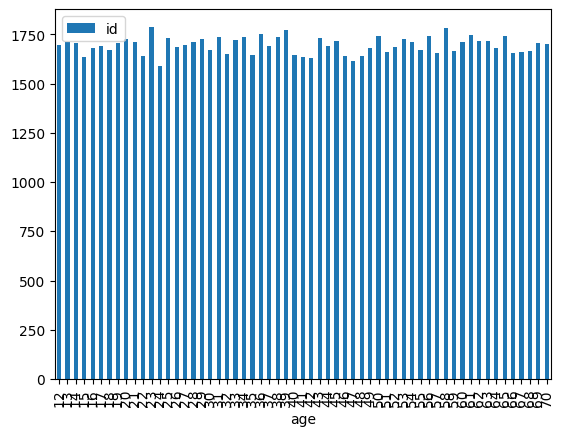

In [82]:
users_age = pd.DataFrame(users.groupby(['age'])['id'].count())
users_age.plot(kind="bar",stacked=True)

##### The age of customers is spread between 12 and 70 with fairly even amounts of each age

<Axes: xlabel='country'>

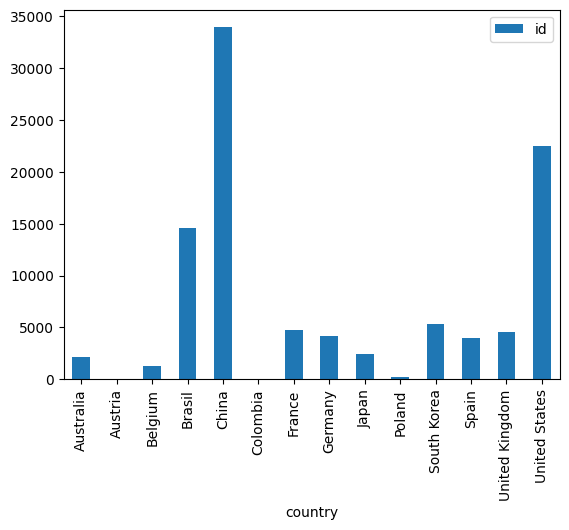

In [83]:
users_by_country = pd.DataFrame(users.groupby(['country'])['id'].count())
users_by_country.plot(kind="bar",stacked=True)

##### The countries with the largest number of users are China, United States, and Brazil. The countries with the smallest number of users are Poland, Columbia, and Austria.

##### Create a dataframe that is based on users purchases(orders) and the users table, this will be accomplished through a merge. 

In [84]:
orders_col_rename = orders.rename(columns={'user_id':'id'})

In [85]:
number_of_order_by_user = pd.DataFrame(orders.groupby(['user_id'])['order_id'].count())

In [86]:
join_orders_users = pd.merge(users,orders_col_rename, on=["id"],how="outer")
join_orders_users_1 = pd.DataFrame(join_orders_users[['id','age','gender_x','country','order_id','returned_at','num_of_item']])

##### Define and apply a function that will return a numerical value based on if an order was returned or not. Add a column that can be used to count the numer of orders that each customer has placed.

In [87]:
def return_numerical(return_val):
  val = pd.isnull(return_val)
  if val == True:
    return 0
  else:
    return 1


join_orders_users_1['return_numerical_value']=join_orders_users_1.apply(lambda x : return_numerical(x['returned_at']) , axis=1)

join_orders_users_1['order_val_for_counting']=1

##### Create a dataframe that groups by the users id, age, gender, and country. The columns for the number of items purchased, the number of returns made, and the number of orders will be summed to find the total values of each column per user.

In [88]:
order_users_agg_1 = join_orders_users_1.groupby(['id','age','gender_x','country'])['num_of_item','return_numerical_value','order_val_for_counting'].sum()

<ipython-input-88-be4dc9582c27>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  order_users_agg_1 = join_orders_users_1.groupby(['id','age','gender_x','country'])['num_of_item','return_numerical_value','order_val_for_counting'].sum()


##### Analysis of the dataframe

In [89]:
agg_gender_item_mean = order_users_agg_1.groupby(['gender_x'])['num_of_item'].mean()
agg_gender_item_mean

gender_x
F      1.8235
M    1.802378
Name: num_of_item, dtype: Float64

<Axes: xlabel='age'>

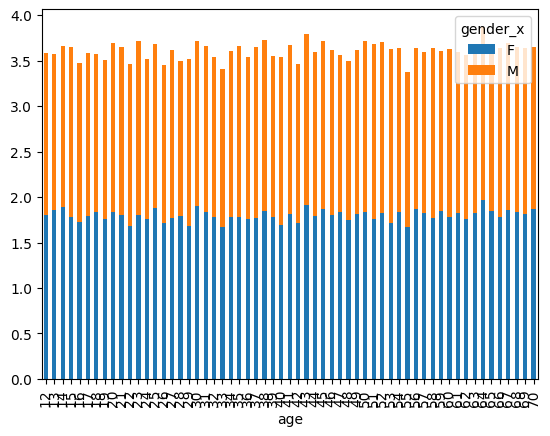

In [ ]:
agg_age_gender_item_mean = order_users_agg_1.groupby(['age','gender_x'])['num_of_item'].mean().unstack()
agg_age_gender_item_mean.plot(kind="bar",stacked=True)

In [ ]:
agg_country_item_mean = order_users_agg_1.groupby(['country'])['num_of_item'].mean()
agg_country_item_mean

country
Australia         1.770009
Austria                3.0
Belgium            1.78703
Brasil            1.810412
China             1.806561
Colombia          1.555556
Deutschland            2.5
España                 1.0
France            1.835605
Germany           1.807804
Japan             1.816598
Poland            1.840816
South Korea       1.822172
Spain             1.778603
United Kingdom    1.810671
United States     1.789785
Name: num_of_item, dtype: Float64

##### The number of total items purchased does not vary greatly based on the age, gender, or country of the user. Austria has a high number of items purchased, likely due to the small amount of users in this country. Spain has a low number of items purchased, likely due to the same reason.

In [91]:
agg_gender_item_mean = order_users_agg_1.groupby(['gender_x'])['return_numerical_value'].mean()
agg_gender_item_mean

gender_x
F    0.125852
M    0.122365
Name: return_numerical_value, dtype: float64

<Axes: xlabel='age'>

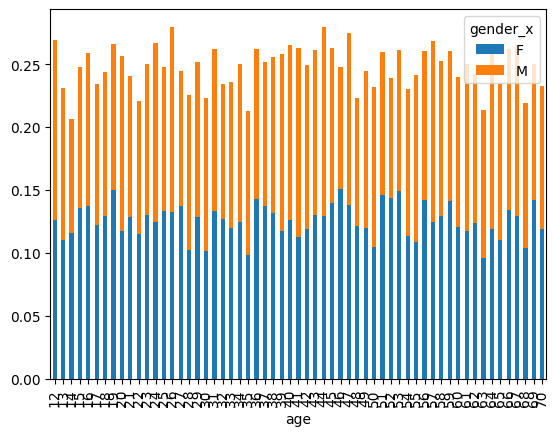

In [93]:
agg_age_gender_item_mean = order_users_agg_1.groupby(['age','gender_x'])['return_numerical_value'].mean().unstack()
agg_age_gender_item_mean.plot(kind="bar",stacked=True)

In [94]:
agg_country_item_mean = order_users_agg_1.groupby(['country'])['return_numerical_value'].mean()
agg_country_item_mean

country
Australia         0.123580
Austria           0.000000
Belgium           0.141494
Brasil            0.125600
China             0.123387
Colombia          0.000000
France            0.122367
Germany           0.119286
Japan             0.127642
Poland            0.104803
South Korea       0.129385
Spain             0.108630
United Kingdom    0.126444
United States     0.125510
Name: return_numerical_value, dtype: float64

##### The number of returns a user makes is not greatly influenced by their age, gender, or country.

In [95]:
agg_gender_item_mean = order_users_agg_1.groupby(['gender_x'])['order_val_for_counting'].mean()
agg_gender_item_mean

gender_x
F    1.450041
M    1.447096
Name: order_val_for_counting, dtype: float64

<Axes: xlabel='age'>

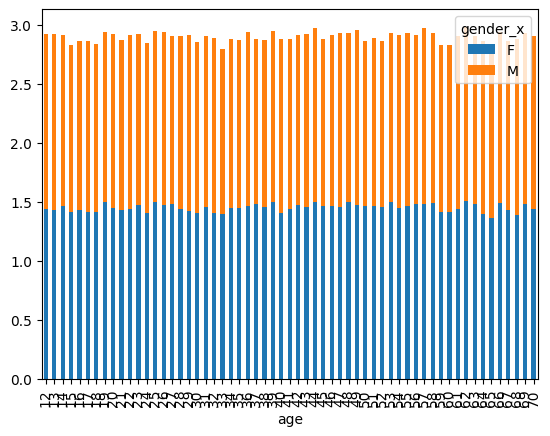

In [96]:
agg_age_gender_item_mean = order_users_agg_1.groupby(['age','gender_x'])['order_val_for_counting'].mean().unstack()
agg_age_gender_item_mean.plot(kind="bar",stacked=True)

In [97]:
agg_country_item_mean = order_users_agg_1.groupby(['country'])['order_val_for_counting'].mean()
agg_country_item_mean

country
Australia         1.447070
Austria           1.200000
Belgium           1.477742
Brasil            1.450665
China             1.446926
Colombia          1.545455
France            1.473673
Germany           1.435952
Japan             1.467468
Poland            1.484716
South Korea       1.456243
Spain             1.447817
United Kingdom    1.454763
United States     1.439952
Name: order_val_for_counting, dtype: float64

#####The number of orders placed by a customer is also not greatly influenced by the users age, gender, or country. 

#### Web Activity of Users

##### Create a dataframe from SQL that will include the traffic source and the number of purchase, cart, and product events for each traffic source as well as the proportion of total events each event segment makes up.

In [98]:
sql = '''
SELECT
  traffic_source,
  SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) num_purchase,
  SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) num_cart,
  SUM(CASE WHEN event_type = 'product' THEN 1 ELSE 0 END) num_product,
  COUNT(*) all_events,
  SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END)/COUNT(*) AS prop_purchase,
  SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END)/COUNT(*) AS prop_cart,
  SUM(CASE WHEN event_type = 'product' THEN 1 ELSE 0 END)/COUNT(*) AS prop_product
FROM
  `bigquery-public-data.thelook_ecommerce.events`
GROUP BY 
  traffic_source
'''

traffic_views = pd.io.gbq.read_gbq(sql,project_id=project_id)

In [100]:
traffic_views

,traffic_source,num_purchase,num_cart,num_product,all_events,prop_purchase,prop_cart,prop_product
0,Adwords,54075,177793,252996,726471,0.074435,0.244735,0.348253
1,Email,81902,268383,380609,1094731,0.074815,0.245159,0.347674
2,Facebook,18127,59849,84570,243295,0.074506,0.245994,0.347603
3,YouTube,18147,59330,84353,242433,0.074854,0.244727,0.347944
4,Organic,9044,29740,42319,121487,0.074444,0.244800,0.348342


##### Email has the largest number of events and purchases. Organic is the smallest number of purchases and total events. The proptions of each event category remains fairly even for each traffic source.

# Categorization of Users
<a id='Analysis_Case_References_by_Subject_in_each_Neighborhood'></a>

---
-Add a column to the users dataframe what the users highest category of purchase is <br>
-Create a bar plot showing the most popular purchase categories  <br>
-Create a dataframe from an sql query for user orders that are not returned or cancelled; add dummy coding <br>
-Create a dataframe for user product categories where the order is not returned or cancelled; add dummy coding <br>
-Create a dataframe from an SQL query that includes country, age, gender, and traffic_source of the user; add dummy coding <br>
-Create a dataframe of the number of events a user makes before purchase; add dummy coding <br>
-Check the dataframes size and join; drop all NA values <br>
-Use k-means to create clusters <br>
-Find cluster means <br>
-Percent difference with cluster means <br>
-Create names for each cluster  <br>

In [101]:
sql = '''
SELECT 
  user_id,
  count(*) order_count 
FROM `bigquery-public-data.thelook_ecommerce.orders` 
where status not in ('Returned','Cancelled')
group by 1
'''

user_order_count = pd.io.gbq.read_gbq(sql,project_id=project_id,
                                      index_col='user_id')

In [102]:
user_orders = pd.get_dummies(user_order_count['order_count'],prefix='orders')

In [103]:
sql = '''
SELECT
  user_id,
  p.category,
  COUNT(*) purchase_count
FROM
  `bigquery-public-data.thelook_ecommerce.order_items` oi
JOIN
  `bigquery-public-data.thelook_ecommerce.products` p
ON
  oi.product_id = p.id
WHERE
  status NOT IN ('Returned','Cancelled')
GROUP BY 1,2
'''

user_products_cat = pd.io.gbq.read_gbq(sql,project_id=project_id,
                                      index_col='user_id')

In [104]:
user_categories = pd.get_dummies(user_products_cat['category'],prefix='cat').groupby('user_id').max()

In [105]:
sql = '''
SELECT
  *
FROM
  `bigquery-public-data.thelook_ecommerce.users`
'''

user_demo = pd.io.gbq.read_gbq(sql,project_id=project_id,
                                      index_col='id')

In [106]:
user_country = pd.get_dummies(user_demo['country'],prefix='country')

In [107]:
user_gender = pd.get_dummies(user_demo['gender'],prefix='sex')

In [108]:
user_age = pd.get_dummies(pd.qcut(user_demo['age'], q = 5, labels = range(5)),prefix='age')

In [109]:
user_traffic = pd.get_dummies(user_demo['traffic_source'],prefix='traffic')

In [110]:
sql = '''
SELECT
  user_id,
  SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) num_purchase,
  SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) num_cart,
  SUM(CASE WHEN event_type = 'product' THEN 1 ELSE 0 END) num_product,
  COUNT(*) all_events
FROM
  `bigquery-public-data.thelook_ecommerce.events`
WHERE
  user_id IS NOT NULL
GROUP BY
  1
'''

user_web = pd.io.gbq.read_gbq(sql,project_id=project_id,
                                      index_col='user_id')

In [111]:
user_web['event_per_purchase'] = round(user_web['all_events']/user_web['num_purchase'])
user_web['event_per_purchase'].value_counts().sort_index()

5.0     47766
6.0      8954
7.0     11267
8.0      1350
9.0      1991
10.0     3961
11.0     1958
12.0      154
13.0     2597
Name: event_per_purchase, dtype: Int64

In [112]:
user_events_per_purchase = pd.get_dummies(pd.qcut(user_web['event_per_purchase'],q=4,labels=range(2),duplicates='drop'),prefix='events_per_purchase')

In [113]:
user_web['avg_cart_size'] = round(user_web['num_cart']/user_web['num_purchase'])
user_web['avg_cart_size'].value_counts()

1.0    49184
2.0    21588
3.0     6475
4.0     2751
Name: avg_cart_size, dtype: Int64

In [114]:
user_avg_cart_size = pd.get_dummies((user_web['avg_cart_size']),prefix = 'avg_cart_size')

In [115]:
dfs = [user_orders,
       user_categories,
       user_country,
       user_gender,
       user_age,
       user_traffic,
       user_events_per_purchase,
       user_avg_cart_size]
for df in dfs:
  print(df.shape)

(66116, 4)
(66116, 26)
(100000, 14)
(100000, 2)
(100000, 5)
(100000, 5)
(79998, 2)
(79998, 4)


In [116]:
user_all = user_country.join(user_categories,how='left').\
join(user_orders,how='left').\
join(user_gender).join(user_age).join(user_traffic).\
join(user_events_per_purchase,how='left').\
join(user_avg_cart_size,how='left')

In [117]:
user_all.dropna(inplace=True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

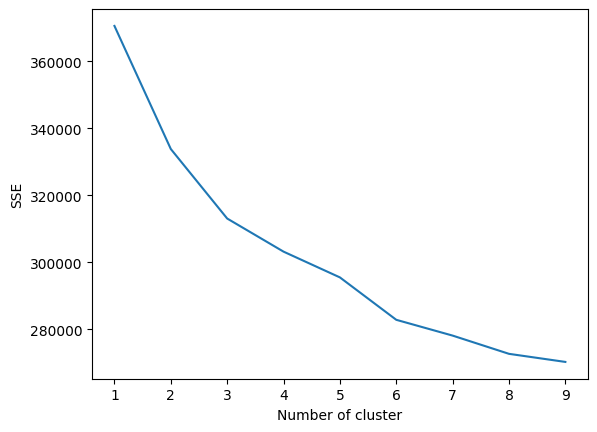

In [118]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_all)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [119]:
kmeans = KMeans(n_clusters=7, max_iter=1000).fit(user_all)
user_all["clusters"] = kmeans.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [120]:
cluster_means = user_all.groupby('clusters').mean()

In [122]:
percent_diff = cluster_means/user_all.mean()-1
percent_diff = percent_diff.T

In [123]:
print(percent_diff.to_string())

clusters                                  0         1         2         3         4         5         6
age_0                             -0.005673  0.009106  0.043053 -0.026818 -0.009857  0.014710 -0.015504
age_1                             -0.006590  0.010682  0.037309 -0.047387  0.000434 -0.003798  0.002403
age_2                              0.002617 -0.004617 -0.019023  0.022740 -0.011955  0.014400  0.025410
age_3                              0.001348  0.008230 -0.025984  0.025702 -0.014513  0.014405  0.025848
age_4                              0.009002 -0.025342 -0.038472  0.028098  0.038723 -0.042851 -0.041021
avg_cart_size_1.0                  0.663630 -1.000000 -1.000000 -1.000000  0.663630  0.663630 -1.000000
avg_cart_size_2.0                 -1.000000  2.553286  2.553286 -0.065800 -1.000000 -1.000000 -0.109592
avg_cart_size_3.0                 -1.000000 -1.000000 -1.000000  5.260821 -1.000000 -1.000000  5.393535
avg_cart_size_4.0                 -1.000000 -1.000000 -1.000000 

In [124]:
cluster_names = {0:'Dutch women from emails with small carts and one order buying fancy clothes',
                 1:'Spanish men who shop for fancy clothes from Facebook with one order and a small cart',
                 2:'Columbian men buying regular clothes in many orders and large carts',
                 3:'Columbian men from Facebook buying all different things in many orders and large carts ',
                 4:'Dutch women from emails buying a mix of fancy and comfortable clothes in many orders with small carts',
                 5:'Austrian men buying fancy clothes in many orders and small carts',
                 6:'French men buying comfortable clothes in one order and a small cart'
                 }

In [125]:
user_all['clusters'].replace(cluster_names)

id
27189    Dutch women from emails buying a mix of fancy ...
29496    Dutch women from emails with small carts and o...
56597    Dutch women from emails with small carts and o...
62576    Dutch women from emails with small carts and o...
94088    Spanish men who shop for fancy clothes from Fa...
                               ...                        
64126    Dutch women from emails buying a mix of fancy ...
7426     Dutch women from emails buying a mix of fancy ...
19609    Columbian men from Facebook buying all differe...
26726    Columbian men from Facebook buying all differe...
65035    Dutch women from emails with small carts and o...
Name: clusters, Length: 66116, dtype: object

##### Cluster names were assigned based on the correlation between the group and the category names used to create clusters. Fancy clothes include suits, dresses, skirts while everyday clothes include leggings, shorts, t-shirts, etc. Small carts have an average of one or two items while large carts have three or four. The number of orders was categorized as one order or multiple orders including users who made two, three, or four seperate purchases. Country, age and traffic source tended to not have large correlations to any cluster. 